## Packages and paths

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from datetime import datetime

from scipy.interpolate import CubicSpline
from scipy.interpolate import splrep, BSpline
from scipy.stats import ttest_1samp

In [146]:
data_source_path = 'data/source/'
data_output_path = 'data/'

## Static definitions

In [147]:
target_countries = ['Iceland', 'Ireland', 'France', 'Portugal', 'Switzerland']

donor_countries = ['Austria', 'Belgium', 'Bulgaria', 
#                    'Cyprus', 
                   'Croatia', 'Czech Republic',
                   'Germany', 'Greece', 'Hungary', 'Italy', 'Lithuania', 'Netherlands', 
                   'Romania', 'Slovakia', 'Spain']

incl_countries = target_countries + donor_countries
incl_countries.sort()

print(len(incl_countries))
print(incl_countries)

19
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czech Republic', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Lithuania', 'Netherlands', 'Portugal', 'Romania', 'Slovakia', 'Spain', 'Switzerland']


In [148]:
incl_years = range(2000, 2020)

print(list(incl_years))

[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


## Functions

In [149]:
def month_name_to_num(month_name):
    return {
            'Jan': 1,
            'Feb': 2,
            'Mar': 3,
            'Apr': 4,
            'May': 5,
            'Jun': 6,
            'Jul': 7,
            'Aug': 8,
            'Sep': 9, 
            'Oct': 10,
            'Nov': 11,
            'Dec': 12
    }[month_name]

In [150]:
def quarter_to_month(quarter):
    return {
            1: 1,
            2: 4,
            3: 7,
            4: 12
    }[quarter]

In [151]:
def month_to_quarter(month):
    return {
            1: 1,
            2: 1,
            3: 1,
            4: 2,
            5: 2,
            6: 2,
            7: 3,
            8: 3,
            9: 3, 
            10: 4,
            11: 4,
            12: 4
    }[month]

## Monthly CO2 data

In [152]:
plt,pl

NameError: name 'pl' is not defined

<AxesSubplot:>

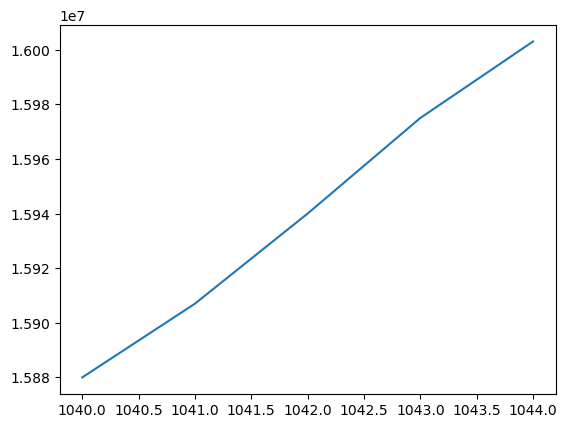

In [153]:
pop_q[pop_q['country']=='Netherlands']['pop_q'][:5].plot()

<AxesSubplot:>

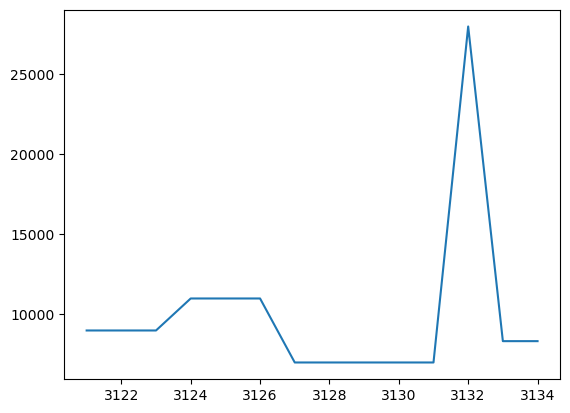

In [154]:
pop_m[pop_m['country']=='Netherlands']['pop_m'][:15].diff(1).dropna().plot()

In [155]:
# read
file_name = 'co2_m'

co2_m_raw = pd.read_csv(f'{data_source_path}{file_name}.csv')
co2_m_raw = co2_m_raw[co2_m_raw.columns.drop(list(co2_m_raw.filter(regex='Unnamed')))]
co2_m_raw

# select
co2_m = co2_m_raw.copy()
co2_m = co2_m[
          (co2_m['Name'].isin(incl_countries)) &
          (co2_m['Year'].isin(incl_years))]
co2_m

# pivot
co2_m = co2_m.melt(id_vars=['Name', 'Year'],value_vars=co2_m.columns[2:])
co2_m['Month'] = co2_m.apply(lambda row: month_name_to_num(row.variable), axis=1)
co2_m['Quarter'] = co2_m.apply(lambda row: month_to_quarter(row.Month), axis=1)
co2_m['date'] = pd.to_datetime(dict(year=co2_m.Year, month=co2_m.Month, day=1))
co2_m = co2_m.drop('variable', axis=1)
co2_m

co2_m = co2_m[['Name', 'date', 'value']]
co2_m.columns = ['country', 'date', 'co2_m']
co2_m = co2_m.sort_values(by=['country', 'date'])
co2_m['co2_m'] = co2_m['co2_m']*1000
co2_m = co2_m.reset_index(drop=True)
co2_m

print(len(co2_m['country'].unique()))
print(co2_m['country'].unique())

co2_m.to_csv(f'{data_output_path}{file_name}_processed.csv')

co2_m

19
['Austria' 'Belgium' 'Bulgaria' 'Croatia' 'Czech Republic' 'France'
 'Germany' 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Italy' 'Lithuania'
 'Netherlands' 'Portugal' 'Romania' 'Slovakia' 'Spain' 'Switzerland']


,country,date,co2_m
0,Austria,2000-01-01,9726927.646
1,Austria,2000-02-01,8532685.059
2,Austria,2000-03-01,8134567.013
3,Austria,2000-04-01,6546737.758
4,Austria,2000-05-01,5603261.736
...,...,...,...
4555,Switzerland,2019-08-01,2793634.688
4556,Switzerland,2019-09-01,3445179.636
4557,Switzerland,2019-10-01,3819263.405
4558,Switzerland,2019-11-01,4487169.820


In [156]:
# read
file_name = 'co2_q'

co2_q = pd.DataFrame({'co2_q' : [],
                             'country' : []})

for country in co2_m['country'].unique():
    co2_country = co2_m.copy()
    co2_country = co2_country[co2_country['country']==country].rename(columns={"co2_m": "co2_q"})
    co2_country = co2_country.set_index('date')['co2_q']
    co2_country = co2_country.resample('Q', convention='start').sum().to_frame()
    co2_country['country'] = [country]*len(co2_country)
    co2_q = pd.concat([co2_q, co2_country], axis=0)

co2_q = co2_q.reset_index().rename(columns={'index': 'date'})
co2_q['date'] = [co2_m['date'][3*i].to_pydatetime() for i in range(0,int(len(co2_m)/3))]
co2_q['date'] = pd.to_datetime(co2_q['date'].astype(str).replace({'-10':'-12'}, regex=True)).dt.to_period('M')
# co2_q['date'] = pd.to_datetime(co2_q['date'].astype(str))
co2_q = co2_q[['country', 'date', 'co2_q']]

co2_q.to_csv(f'{data_output_path}{file_name}_processed.csv')

co2_q

,country,date,co2_q
0,Austria,2000-01,2.639418e+07
1,Austria,2000-04,1.716434e+07
2,Austria,2000-07,1.540407e+07
3,Austria,2000-12,2.302421e+07
4,Austria,2001-01,2.673684e+07
...,...,...,...
1515,Switzerland,2018-12,1.323977e+07
1516,Switzerland,2019-01,1.362700e+07
1517,Switzerland,2019-04,1.037795e+07
1518,Switzerland,2019-07,9.078898e+06


## Quarterly Population Data

In [157]:
file_name = 'pop_q'
measure = ['PERSA']
power = 1000

# read
pop_q_raw = pd.read_csv(f'{data_source_path}{file_name}.csv')
pop_q_raw

# transform
pop_q = pop_q_raw.copy()
pop_q = pop_q.replace({'Slovak Republic': 'Slovakia'})
pop_q['year'] = pop_q['TIME'].str[:4].astype(int)
pop_q['quarter'] = pop_q['TIME'].str[6:].astype(int)
pop_q['month'] = pop_q.apply(lambda row: quarter_to_month(row.quarter), axis=1)
pop_q['date'] = pd.to_datetime(dict(year=pop_q.year, month=pop_q.month, day=1)).dt.to_period('M')
pop_q['Value_cor'] = pop_q['Value']*power
pop_q

# select
pop_q = pop_q[(pop_q['Country'].isin(incl_countries))
          & (pop_q['year'].isin(incl_years))
          & (pop_q['MEASURE'].isin(measure))]
pop_q

# pivot
pop_q = pop_q[['Country', 'date', 'Value_cor']]
pop_q.columns = ['country', 'date', 'pop_q']
pop_q = pop_q.sort_values(by=['country', 'date'])
pop_q = pop_q.reset_index(drop=True)
pop_q

print(len(pop_q['country'].unique()))
print(pop_q['country'].unique())

pop_q.to_csv(f'{data_output_path}{file_name}_processed.csv')

pop_q

19
['Austria' 'Belgium' 'Bulgaria' 'Croatia' 'Czech Republic' 'France'
 'Germany' 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Italy' 'Lithuania'
 'Netherlands' 'Portugal' 'Romania' 'Slovakia' 'Spain' 'Switzerland']


,country,date,pop_q
0,Austria,2000-01,8003000.0
1,Austria,2000-04,8008100.0
2,Austria,2000-07,8014100.0
3,Austria,2000-12,8021000.0
4,Austria,2001-01,8028700.0
...,...,...,...
1511,Switzerland,2018-12,8542300.0
1512,Switzerland,2019-01,8555500.0
1513,Switzerland,2019-04,8570100.0
1514,Switzerland,2019-07,8586500.0


In [158]:
pop_q[pop_q['country']=='Netherlands']['pop_q']

1040    15880000.0
1041    15907000.0
1042    15940000.0
1043    15975000.0
1044    16003000.0
           ...    
1115    17278000.0
1116    17294000.0
1117    17317000.0
1118    17357000.0
1119    17396000.0
Name: pop_q, Length: 80, dtype: float64

In [159]:
file_name = 'pop_m'

pop_m = pd.DataFrame({'pop_m' : [],
                             'country' : []})

for country in pop_q['country'].unique():
    pop_country = pop_q.copy()
    pop_country = pop_country[pop_country['country']==country].rename(columns={"pop_q": "pop_m"})
    pop_country = pop_country.set_index('date')['pop_m']
    pop_country = pop_country.resample('M').interpolate().to_frame()
    pop_country['country'] = [country]*len(pop_country)
    pop_m = pd.concat([pop_m, pop_country], axis=0)

pop_m = pop_m.reset_index().rename(columns={'index': 'date'})
pop_m['date'] = pd.to_datetime(pop_m['date'].astype(str))
pop_m = pop_m[['country', 'date', 'pop_m']]

pop_m.to_csv(f'{data_output_path}{file_name}_processed.csv')

pop_m

,country,date,pop_m
0,Austria,2000-01-01,8003000.0
1,Austria,2000-02-01,8004700.0
2,Austria,2000-03-01,8006400.0
3,Austria,2000-04-01,8008100.0
4,Austria,2000-05-01,8010100.0
...,...,...,...
4555,Switzerland,2019-08-01,8589980.0
4556,Switzerland,2019-09-01,8593460.0
4557,Switzerland,2019-10-01,8596940.0
4558,Switzerland,2019-11-01,8600420.0


In [160]:
pop_m[pop_m['country']=='Netherlands']['pop_m'][:12].to_frame().reset_index(drop=True)

,pop_m
0,15880000.0
1,15889000.0
2,15898000.0
3,15907000.0
4,15918000.0
5,15929000.0
6,15940000.0
7,15947000.0
8,15954000.0
9,15961000.0


In [161]:
np.log(pop_m[pop_m['country']=='Netherlands']['pop_m']).diff(12).dropna()

3132    0.007716
3133    0.007670
3134    0.007624
3135    0.007578
3136    0.007552
          ...   
3355    0.006587
3356    0.006642
3357    0.006697
3358    0.006751
3359    0.006806
Name: pop_m, Length: 228, dtype: float64

[]

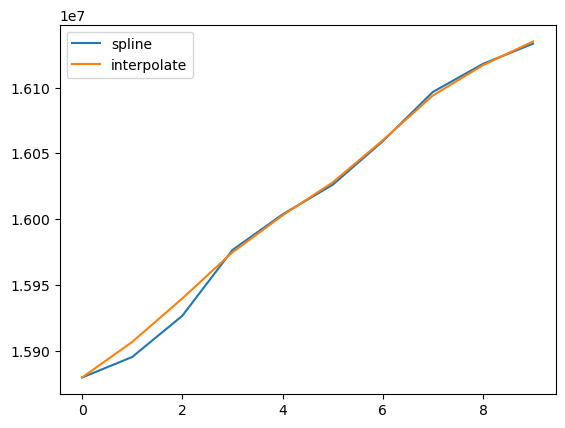

In [162]:
y = pop_q[pop_q['country']=='Netherlands']['pop_q']
tck_s = splrep(y.index, y, s=len(y.index))
plt.plot(tck_s[1][:10], label='spline')
plt.plot(y[:10].reset_index(drop=True), label='interpolate')
plt.legend()
plt.plot()

<AxesSubplot:>

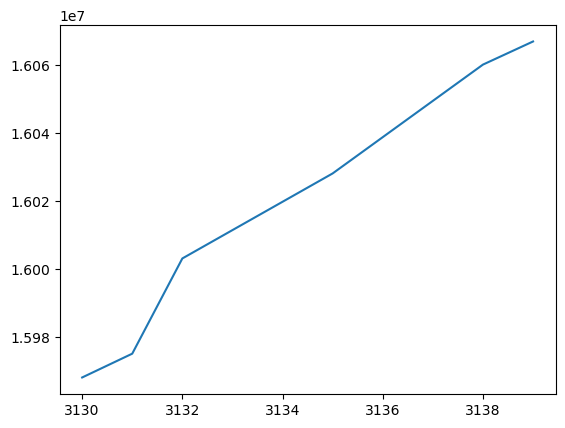

In [163]:
pop_m[pop_m['country']=='Netherlands']['pop_m'][10:20].plot()

## Quarterly GDP Data

In [164]:
file_name = 'gdp_q'
measure = ['CPCARSA']
power = 1e6

# read
gdp_q_raw = pd.read_csv(f'{data_source_path}{file_name}.csv')
gdp_q_raw

# transform
gdp_q = gdp_q_raw.copy()
gdp_q = gdp_q.replace({'Slovak Republic': 'Slovakia'})
gdp_q['year'] = gdp_q['TIME'].str[:4].astype(int)
gdp_q['quarter'] = gdp_q['TIME'].str[6:].astype(int)
gdp_q['month'] = gdp_q.apply(lambda row: quarter_to_month(row.quarter), axis=1)
gdp_q['date'] = pd.to_datetime(dict(year=gdp_q.year, month=gdp_q.month, day=1)).dt.to_period('M')
gdp_q['Value_cor'] = gdp_q['Value']*power
gdp_q

# select
gdp_q = gdp_q[(gdp_q['Country'].isin(incl_countries))
          & (gdp_q['year'].isin(incl_years))
          & (gdp_q['MEASURE'].isin(measure))]
gdp_q

# pivot
gdp_q = gdp_q[['Country', 'date', 'Value_cor']]
gdp_q.columns = ['country', 'date', 'gdp_q']
gdp_q = gdp_q.sort_values(by=['country', 'date', 'gdp_q'])
gdp_q = gdp_q.reset_index(drop=True)
gdp_q

print(len(gdp_q['country'].unique()))
print(gdp_q['country'].unique())

gdp_q.to_csv(f'{data_output_path}{file_name}_processed.csv')

gdp_q

19
['Austria' 'Belgium' 'Bulgaria' 'Croatia' 'Czech Republic' 'France'
 'Germany' 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Italy' 'Lithuania'
 'Netherlands' 'Portugal' 'Romania' 'Slovakia' 'Spain' 'Switzerland']


,country,date,gdp_q
0,Austria,2000-01,2.309478e+11
1,Austria,2000-04,2.344696e+11
2,Austria,2000-07,2.367135e+11
3,Austria,2000-12,2.395027e+11
4,Austria,2001-01,2.377669e+11
...,...,...,...
1515,Switzerland,2018-12,6.086313e+11
1516,Switzerland,2019-01,6.137651e+11
1517,Switzerland,2019-04,6.214928e+11
1518,Switzerland,2019-07,6.270779e+11


In [165]:
file_name = 'gdp_q'
power = 1e6

# read
gdp_q_raw = pd.read_csv(f'{data_source_path}{file_name}.csv')
gdp_q_raw

,LOCATION,Country,SUBJECT,Subject,MEASURE,Measure,FREQUENCY,Frequency,TIME,Period,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,NZL,New Zealand,B1_GA,Gross domestic product at market prices - outp...,GPSA,Growth rate based on seasonally adjusted volum...,Q,Quarterly,1990-Q1,Q1-1990,PC,Percentage,0,Units,NaN,NaN,-0.171545,NaN,NaN
1,NZL,New Zealand,B1_GA,Gross domestic product at market prices - outp...,GPSA,Growth rate based on seasonally adjusted volum...,Q,Quarterly,1990-Q2,Q2-1990,PC,Percentage,0,Units,NaN,NaN,-0.014320,NaN,NaN
2,NZL,New Zealand,B1_GA,Gross domestic product at market prices - outp...,GPSA,Growth rate based on seasonally adjusted volum...,Q,Quarterly,1990-Q3,Q3-1990,PC,Percentage,0,Units,NaN,NaN,0.913029,NaN,NaN
3,NZL,New Zealand,B1_GA,Gross domestic product at market prices - outp...,GPSA,Growth rate based on seasonally adjusted volum...,Q,Quarterly,1990-Q4,Q4-1990,PC,Percentage,0,Units,NaN,NaN,1.170877,NaN,NaN
4,NZL,New Zealand,B1_GA,Gross domestic product at market prices - outp...,GPSA,Growth rate based on seasonally adjusted volum...,Q,Quarterly,1991-Q1,Q1-1991,PC,Percentage,0,Units,NaN,NaN,-2.423371,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22613,LVA,Latvia,B1_GE,Gross domestic product - expenditure approach,GCUMSA,Cumulative growth based on seasonally adjusted...,Q,Quarterly,2022-Q1,Q1-2022,PC,Percentage,0,Units,NaN,NaN,4.725441,NaN,NaN
22614,LVA,Latvia,B1_GE,Gross domestic product - expenditure approach,GCUMSA,Cumulative growth based on seasonally adjusted...,Q,Quarterly,2022-Q2,Q2-2022,PC,Percentage,0,Units,NaN,NaN,4.551506,NaN,NaN
22615,LVA,Latvia,B1_GE,Gross domestic product - expenditure approach,GCUMSA,Cumulative growth based on seasonally adjusted...,Q,Quarterly,2022-Q3,Q3-2022,PC,Percentage,0,Units,NaN,NaN,3.285551,NaN,NaN
22616,LVA,Latvia,B1_GE,Gross domestic product - expenditure approach,GCUMSA,Cumulative growth based on seasonally adjusted...,Q,Quarterly,2022-Q4,Q4-2022,PC,Percentage,0,Units,NaN,NaN,4.501523,NaN,NaN


In [166]:
file_name = 'gdp_m'

gdp_m = pd.DataFrame({'gdp_m' : [],
                             'country' : []})

for country in gdp_q['country'].unique():
    gdp_country = gdp_q.copy()
    gdp_country = gdp_country[gdp_country['country']==country].rename(columns={"gdp_q": "gdp_m"})
    gdp_country = gdp_country.set_index('date')['gdp_m']
    gdp_country = gdp_country.resample('M').interpolate().to_frame()
    gdp_country['country'] = [country]*len(gdp_country)
    gdp_m = pd.concat([gdp_m, gdp_country], axis=0)
    
gdp_m = gdp_m.reset_index().rename(columns={'index': 'date'})
gdp_m['date'] = pd.to_datetime(gdp_m['date'].astype(str))
gdp_m = gdp_m[['country', 'date', 'gdp_m']]

gdp_m.to_csv(f'{data_output_path}{file_name}_processed.csv')

gdp_m

,country,date,gdp_m
0,Austria,2000-01-01,2.309478e+11
1,Austria,2000-02-01,2.321217e+11
2,Austria,2000-03-01,2.332957e+11
3,Austria,2000-04-01,2.344696e+11
4,Austria,2000-05-01,2.352176e+11
...,...,...,...
4555,Switzerland,2019-08-01,6.281104e+11
4556,Switzerland,2019-09-01,6.291429e+11
4557,Switzerland,2019-10-01,6.301753e+11
4558,Switzerland,2019-11-01,6.312078e+11


## Total join

In [167]:
file_name = 'total_quarterly'

total_quarterly = co2_q.copy()
total_quarterly = total_quarterly.merge(pop_q, how='left', on=['date', 'country'])
total_quarterly = total_quarterly.merge(gdp_q, how='left', on=['date', 'country'])

total_quarterly['co2_q_cap'] = total_quarterly['co2_q'] / total_quarterly['pop_q']
total_quarterly['gdp_q_cap'] = total_quarterly['gdp_q'] / total_quarterly['pop_q']

total_quarterly.to_csv(f'{data_output_path}{file_name}.csv', header=True, index=False)

total_quarterly

,country,date,co2_q,pop_q,gdp_q,co2_q_cap,gdp_q_cap
0,Austria,2000-01,2.639418e+07,8003000.0,2.309478e+11,3.298036,28857.653380
1,Austria,2000-04,1.716434e+07,8008100.0,2.344696e+11,2.143372,29279.054957
2,Austria,2000-07,1.540407e+07,8014100.0,2.367135e+11,1.922121,29537.128311
3,Austria,2000-12,2.302421e+07,8021000.0,2.395027e+11,2.870492,29859.456427
4,Austria,2001-01,2.673684e+07,8028700.0,2.377669e+11,3.330158,29614.620051
...,...,...,...,...,...,...,...
1515,Switzerland,2018-12,1.323977e+07,8542300.0,6.086313e+11,1.549907,71249.113236
1516,Switzerland,2019-01,1.362700e+07,8555500.0,6.137651e+11,1.592777,71739.243761
1517,Switzerland,2019-04,1.037795e+07,8570100.0,6.214928e+11,1.210948,72518.733737
1518,Switzerland,2019-07,9.078898e+06,8586500.0,6.270779e+11,1.057346,73030.676061


In [168]:
file_name = 'total_monthly'

total_monthly = co2_m.copy()
total_monthly = total_monthly.merge(pop_m, how='left', on=['date', 'country'])
total_monthly = total_monthly.merge(gdp_m, how='left', on=['date', 'country'])

total_monthly['co2_m_cap'] = total_monthly['co2_m'] / total_monthly['pop_m']
total_monthly['gdp_m_cap'] = total_monthly['gdp_m'] / total_monthly['pop_m']

total_monthly.to_csv(f'{data_output_path}{file_name}.csv', header=True, index=False)

total_monthly

,country,date,co2_m,pop_m,gdp_m,co2_m_cap,gdp_m_cap
0,Austria,2000-01-01,9726927.646,8003000.0,2.309478e+11,1.215410,28857.653380
1,Austria,2000-02-01,8532685.059,8004700.0,2.321217e+11,1.065959,28998.180236
2,Austria,2000-03-01,8134567.013,8006400.0,2.332957e+11,1.016008,29138.647415
3,Austria,2000-04-01,6546737.758,8008100.0,2.344696e+11,0.817514,29279.054957
4,Austria,2000-05-01,5603261.736,8010100.0,2.352176e+11,0.699525,29365.122366
...,...,...,...,...,...,...,...
4555,Switzerland,2019-08-01,2793634.688,8589980.0,6.281104e+11,0.325220,73121.285498
4556,Switzerland,2019-09-01,3445179.636,8593460.0,6.291429e+11,0.400907,73211.821548
4557,Switzerland,2019-10-01,3819263.405,8596940.0,6.301753e+11,0.444258,73302.284301
4558,Switzerland,2019-11-01,4487169.820,8600420.0,6.312078e+11,0.521738,73392.673846


## Total stationary

In [169]:
file_name = 'total_quarterly_stat'

total_quarterly_stat = total_quarterly.copy()

total_quarterly_stat = total_quarterly_stat[['country', 'date', 'co2_q', 'pop_q', 'gdp_q', 
                                         'co2_q_cap', 'gdp_q_cap']]

# co2_diff = 12
# pop_diff = 13
# gdp_diff = 13
# co2_cap_diff = 13
# gdp_cap_diff = 13
# max_diff = max(co2_diff, pop_diff, gdp_diff, co2_cap_diff, gdp_cap_diff)

country_list = []
date_list = []
co2_stat_list = []
pop_stat_list = []
gdp_stat_list = []
co2_cap_stat_list = []
gdp_cap_stat_list = []

for country in total_quarterly_stat['country'].unique():
    total_sub = total_quarterly_stat[total_quarterly_stat['country']==country]
    
    country_list += list(total_sub['country'])
    date_list += list(total_sub['date'])
    
    for series in ['co2_q', 'pop_q', 'gdp_q', 'co2_q_cap', 'gdp_q_cap']:
        total_sub_sub = total_sub[series]
        
        if series == 'co2_q':
            co2_stat_list += list(np.log(total_sub_sub).diff(12))
        elif series == 'pop_q':
            pop_stat_list += list(np.log(total_sub_sub).diff(1).diff(1))
        elif series == 'gdp_q':
            gdp_stat_list += list(np.log(total_sub_sub).diff(1))
        elif series == 'co2_q_cap':
            co2_cap_stat_list += list(np.log(total_sub_sub).diff(1))
        elif series == 'gdp_q_cap':
            gdp_cap_stat_list += list(np.log(total_sub_sub).diff(1))
            
total_quarterly_stat = pd.DataFrame(list(zip(country_list, date_list, co2_stat_list, pop_stat_list, gdp_stat_list, co2_cap_stat_list, gdp_cap_stat_list)), 
                          columns =['country', 'date', 'co2_q_stat', 'pop_q_stat', 'gdp_q_stat', 
                                    'co2_q_cap_stat', 'gdp_q_cap_stat'])

total_quarterly_stat = total_quarterly_stat.dropna(axis=0, how='any').reset_index(drop=True)

total_quarterly_stat.to_csv(f'{data_output_path}{file_name}.csv', header=True, index=False)

total_quarterly_stat

,country,date,co2_q_stat,pop_q_stat,gdp_q_stat,co2_q_cap_stat,gdp_q_cap_stat
0,Austria,2003-01,0.104566,-0.000446,0.010839,0.141264,0.010061
1,Austria,2003-04,0.132660,0.000086,0.005028,-0.403079,0.004164
2,Austria,2003-07,0.151685,0.000738,0.008776,-0.090779,0.007174
3,Austria,2003-12,0.168748,0.000120,0.009117,0.417256,0.007395
4,Austria,2004-01,0.099979,-0.000420,0.019673,0.079425,0.018371
...,...,...,...,...,...,...,...
1287,Switzerland,2018-12,-0.000250,-0.000309,0.008865,0.388153,0.007061
1288,Switzerland,2019-01,-0.064048,-0.000260,0.008400,0.027284,0.006856
1289,Switzerland,2019-04,-0.059667,0.000161,0.012512,-0.274075,0.010807
1290,Switzerland,2019-07,0.032268,0.000207,0.008946,-0.135642,0.007035


In [170]:
file_name = 'total_monthly_stat'

total_monthly_stat = total_monthly.copy()

total_monthly_stat = total_monthly_stat[['country', 'date', 'co2_m', 'pop_m', 'gdp_m', 
                                         'co2_m_cap', 'gdp_m_cap']]

# co2_diff = 12
# pop_diff = 13
# gdp_diff = 13
# co2_cap_diff = 13
# gdp_cap_diff = 13
# max_diff = max(co2_diff, pop_diff, gdp_diff, co2_cap_diff, gdp_cap_diff)

country_list = []
date_list = []
co2_stat_list = []
pop_stat_list = []
gdp_stat_list = []
co2_cap_stat_list = []
gdp_cap_stat_list = []

for country in total_monthly_stat['country'].unique():
    total_sub = total_monthly_stat[total_monthly_stat['country']==country]
    
    country_list += list(total_sub['country'])
    date_list += list(total_sub['date'])
    
    for series in ['co2_m', 'pop_m', 'gdp_m', 'co2_m_cap', 'gdp_m_cap']:
        total_sub_sub = total_sub[series]
        
        if series == 'co2_m':
            co2_stat_list += list(np.log(total_sub_sub).diff(12))
        elif series == 'pop_m':
            pop_stat_list += list(np.log(total_sub_sub).diff(1).diff(1))
        elif series == 'gdp_m':
            gdp_stat_list += list(np.log(total_sub_sub).diff(1))
        elif series == 'co2_m_cap':
            co2_cap_stat_list += list(np.log(total_sub_sub).diff(1))
        elif series == 'gdp_m_cap':
            gdp_cap_stat_list += list(np.log(total_sub_sub).diff(1))
            
total_monthly_stat = pd.DataFrame(list(zip(country_list, date_list, co2_stat_list, pop_stat_list, gdp_stat_list, co2_cap_stat_list, gdp_cap_stat_list)), 
                          columns =['country', 'date', 'co2_m_stat', 'pop_m_stat', 'gdp_m_stat', 
                                    'co2_m_cap_stat', 'gdp_m_cap_stat'])

total_monthly_stat = total_monthly_stat.dropna(axis=0, how='any').reset_index(drop=True)

total_monthly_stat.to_csv(f'{data_output_path}{file_name}.csv', header=True, index=False)

total_monthly_stat

,country,date,co2_m_stat,pop_m_stat,gdp_m_stat,co2_m_cap_stat,gdp_m_cap_stat
0,Austria,2001-01-01,-0.019138,7.874564e-04,-0.007274,0.100990,-0.008233
1,Austria,2001-02-01,0.039611,-6.066812e-04,-0.000168,-0.072598,-0.000521
2,Austria,2001-03-01,0.022160,-1.244510e-07,-0.000168,-0.065585,-0.000521
3,Austria,2001-04-01,0.119718,-1.243633e-07,-0.000168,-0.119950,-0.000521
4,Austria,2001-05-01,0.024326,3.718831e-05,0.001218,-0.251400,0.000828
...,...,...,...,...,...,...,...
4327,Switzerland,2019-08-01,0.027670,-2.316558e-04,0.001645,-0.016895,0.001240
4328,Switzerland,2019-09-01,-0.000445,-1.641248e-07,0.001642,0.209228,0.001237
4329,Switzerland,2019-10-01,0.008483,-1.639919e-07,0.001640,0.102677,0.001235
4330,Switzerland,2019-11-01,-0.004228,-1.638592e-07,0.001637,0.160760,0.001232


Austria: Stationary
Belgium: Stationary
Bulgaria: Stationary
Croatia: Stationary
Czech Republic: Stationary
France: Stationary
Germany: Stationary
Greece: Non-stationary (0.162)
Hungary: Stationary
Iceland: Stationary
Ireland: Stationary
Italy: Stationary
Lithuania: Stationary
Netherlands: Stationary
Portugal: Stationary
Romania: Stationary
Slovakia: Stationary
Spain: Stationary
Switzerland: Stationary


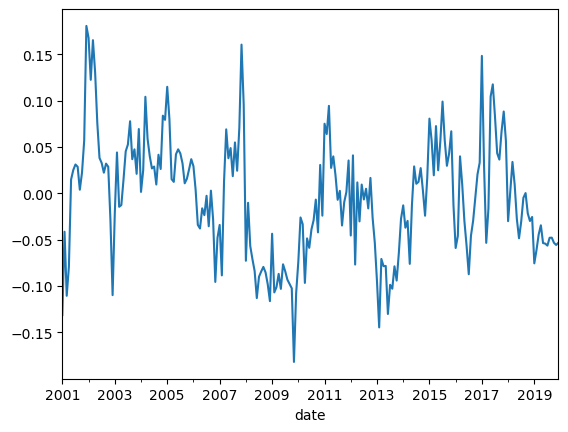

In [177]:
var = 'co2_m'
diff_level = 12

df = total_monthly

for country in df['country'].unique():
    df_country = np.log(df[df['country']==country].set_index('date',drop=True)[var]).diff(diff_level).dropna()
    adf_country = adfuller(df_country)
    if adf_country[1] < 0.1:
        print(f'{country}: Stationary')
        pass
    if adf_country[1] >= 0.1:
        print(f'{country}: Non-stationary ({round(adf_country[1], 3)})')

np.log(df[df['country']=='Spain'].set_index('date',drop=True)[var]).diff(diff_level).dropna().plot();

In [172]:
var = 'co2'
test_adf = total.copy()
test_adf = np.log(test_adf[test_adf['country']=='Netherlands'][var]).diff(1)

print(adfuller(test_adf.dropna()))
plt.plot(test_adf)

NameError: name 'total' is not defined